In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
from sklearn.metrics import classification_report, f1_score

In [18]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [19]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\\python\\ML\\pothole_detection_CNN\\Dataset',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1530 files belonging to 3 classes.


In [20]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [21]:
len(dataset)

48

In [22]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 0 0 0 2 1 2 2 2 2 0 2 2 0 0 2 1 1 2 0 2 2 2 2 2 1 0 0 0 2 1]


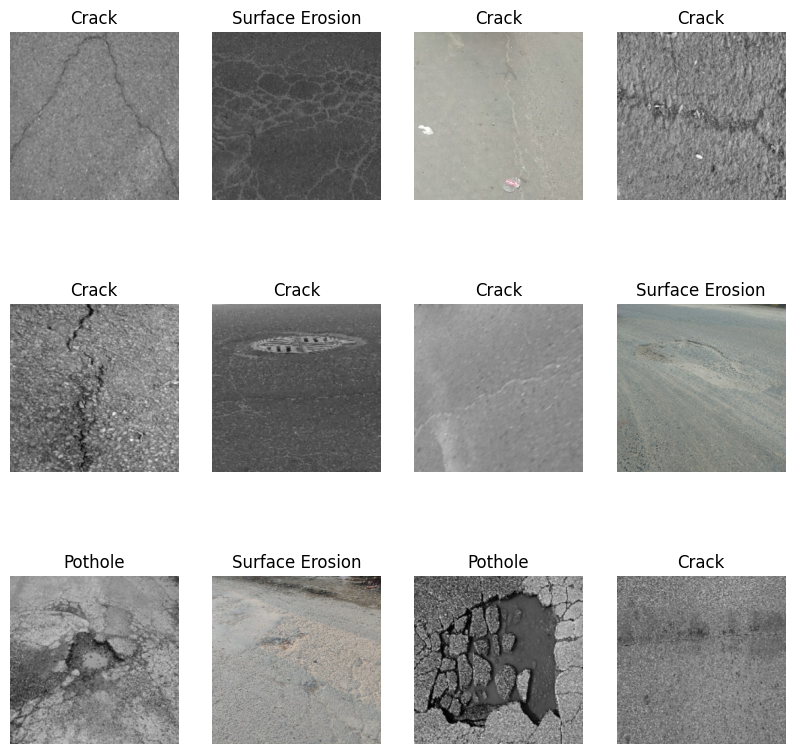

In [23]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [24]:
def partition_data(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds  = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    validation_size = int(val_split * ds_size)
    train_data = ds.take(train_size)
    validation_data = ds.skip(train_size).take(validation_size)
    test_data = ds.skip(train_size).skip(validation_size)
    return train_data, validation_data, test_data
train_data, validation_data, test_data = partition_data(dataset)
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 38
Validation data size: 4
Test data size: 6


In [25]:
len(train_data)
len(validation_data)
len(test_data)

6

In [26]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
])

In [29]:
# Model builders
def build_vgg19_model():
    base = tf.keras.applications.VGG19(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [30]:
model = build_vgg19_model()

In [31]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 8, 8, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [32]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 362s 9s/step - accuracy: 0.4518 - loss: 1.0642 - val_accuracy: 0.6475 - val_loss: 0.9052
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 344s 9s/step - accuracy: 0.5774 - loss: 0.8769 - val_accuracy: 0.6311 - val_loss: 0.8122
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 342s 9s/step - accuracy: 0.6767 - loss: 0.7821 - val_accuracy: 0.6803 - val_loss: 0.7494
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 344s 9s/step - accuracy: 0.7111 - loss: 0.7356 - val_accuracy: 0.7295 - val_loss: 0.6904
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 350s 9s/step - accuracy: 0.7221 - loss: 0.7029 - val_accuracy: 0.7459 - val_loss: 0.6673
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 346s 9s/step - accuracy: 0.7321 - loss: 0.6806 - val_accuracy: 0.7787 - val_loss: 0.6186
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 342s 9s/step - accuracy: 0.7209 - loss: 0.6624 - val_accuracy: 0.8115 - val_loss: 0.5812
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 344s 9s/step - accuracy: 0.7545 - loss: 0.6298 - val_accuracy: 0.8033 - v

In [34]:
scores = model.evaluate(test_data)
scores

6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 8s/step - accuracy: 0.8482 - loss: 0.4231


[0.4114433825016022, 0.8541666865348816]

In [35]:
model.save("Trained Modelv2/VGG19.h5")
model.save("Trained Modelv2/VGG19.keras")

In [36]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 38}

In [37]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [38]:
history.history['accuracy']

[0.5016528964042664,
 0.6000000238418579,
 0.6727272868156433,
 0.7057850956916809,
 0.7247933745384216,
 0.7280991673469543,
 0.7413223385810852,
 0.757851243019104,
 0.7677686214447021,
 0.7603305578231812,
 0.7793388366699219,
 0.7719008326530457,
 0.7793388366699219,
 0.7942149043083191,
 0.7966942191123962,
 0.7793388366699219,
 0.8033058047294617,
 0.800000011920929,
 0.8024793267250061,
 0.7991735339164734,
 0.8008264303207397,
 0.8099173307418823,
 0.800000011920929,
 0.8148760199546814,
 0.7958677411079407,
 0.8148760199546814,
 0.8140496015548706,
 0.8066115975379944,
 0.823966920375824,
 0.8190082907676697,
 0.8190082907676697,
 0.8198347091674805,
 0.823966920375824,
 0.8214876055717468,
 0.8181818127632141,
 0.8256198167800903,
 0.8181818127632141,
 0.828925609588623,
 0.8223140239715576,
 0.8198347091674805,
 0.828925609588623,
 0.831404983997345,
 0.828925609588623,
 0.8272727131843567,
 0.8305785059928894,
 0.8297520875930786,
 0.8388429880142212,
 0.844628095626831,
 0

In [39]:
# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
F1 Score (macro): 0.8496514644290828
F1 Score (weighted): 0.8536203815413823

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.90      0.83      0.86        64
        Pothole       0.88      0.78      0.82        45
Surface Erosion       0.82      0.92      0.86        83

       accuracy                           0.85       192
      macro avg       0.86      0.84      0.85       192
   weighted avg       0.86      0.85      0.85       192



In [40]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

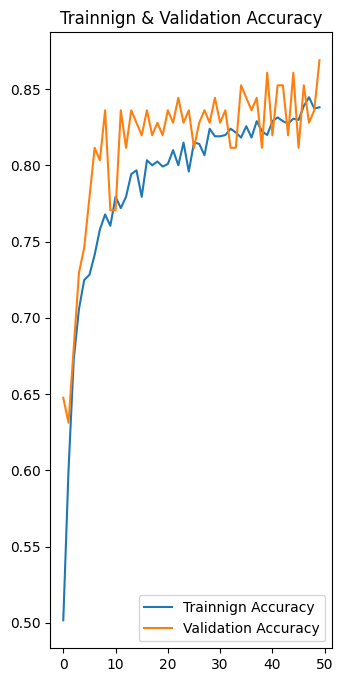

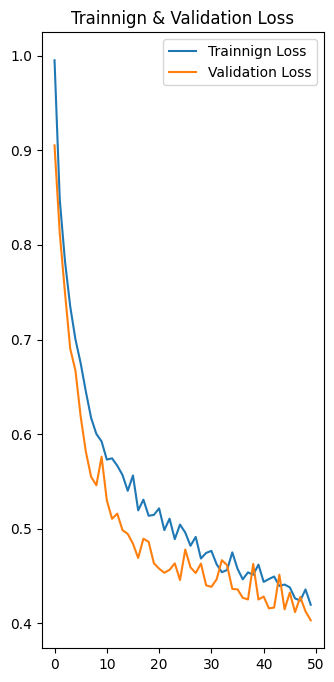

In [41]:

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [42]:
model.evaluate(test_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.8510 - loss: 0.4298


[0.4114433526992798, 0.8541666865348816]

First image to predict
First image actual label:  Pothole
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted Label:  Pothole


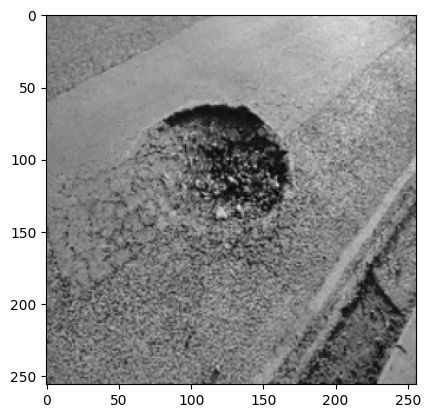

In [43]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
    # Expand image dims and predict
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    # Lighting detection
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()

    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

Confidence:->51.88999938964844 Light:-> Normal lighting
Confidence:->98.54000091552734 Light:-> Normal lighting
Confidence:->92.33999633789062 Light:-> Normal lighting
Confidence:->84.31999969482422 Light:-> Normal lighting
Confidence:->88.23999786376953 Light:-> Normal lighting
Confidence:->96.97000122070312 Light:-> Normal lighting
Confidence:->82.08999633789062 Light:-> Normal lighting
Confidence:->97.73999786376953 Light:-> Normal lighting
Confidence:->68.19999694824219 Light:-> Normal lighting


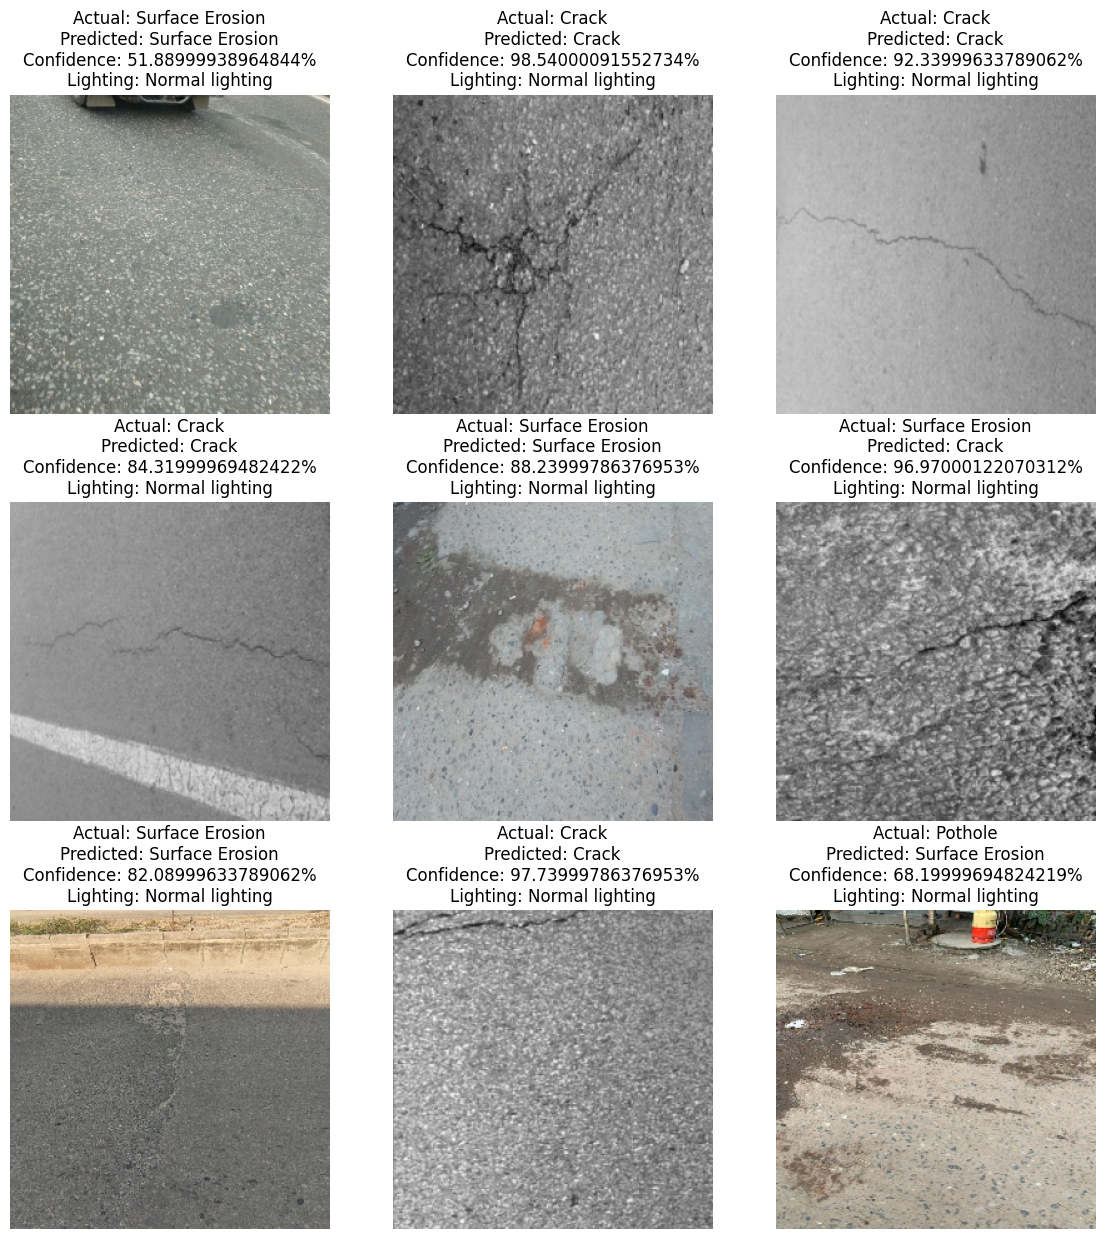

In [50]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [46]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")


Prediction: Surface Erosion, Confidence: 68.19999694824219


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


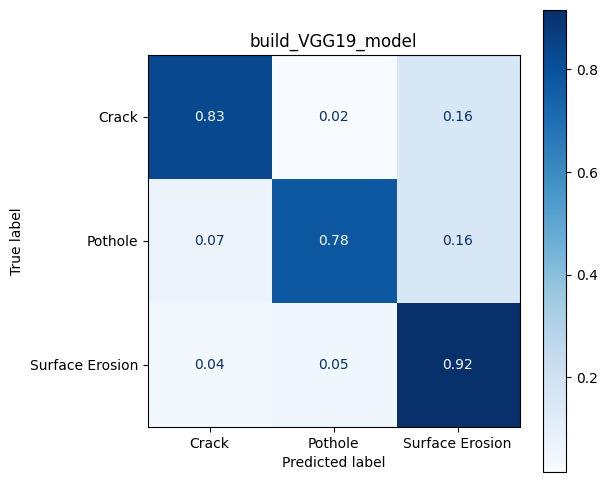

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []
for images, labels in test_data:
    predictions = model.predict(images)
    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("build_VGG19_model")
plt.savefig("Confusion Matrx/VGG19.png", dpi=300, bbox_inches='tight')
plt.show()
